# Polygon merger v2

**Overview:**

This includes functionality to merge polygons from a whole-slide image using an R-tree spatial querying database. This is a generalization of the ``polygon_merger.py`` class which was specific to the case of tiled masks from segmentation algorithms. In brief, here is when it is appropriate to use either workflow. If you have:

- __Tiled masks from segmentation algorithm__: Use ``polygon_merger.py``. That is likely going to be __faster__ than ``polygon_merger_v2.py``, since it takes advantage of the known spatial adjacency between segmentation masks and the available functionality in ``masts_to_annotations_handler.py`` to cut down the search space to a much smaller set of annotations (only those that touch the mak edge). ``polygon_merger_test.py`` runs in ~20 seconds whereas ``polygon_merger_v2_test.py`` runs in ~25 seconds (i.e. 20% slower, but it's not a 100% fair comparison). 

- __Contours (coordinates) from whole slide image__: Use ``polygon_merger_v2.py`` (as shown in this notebook). This is __more general__ and does not require having masks. It is still quite fast since it relies on R-trees to cut down the search space.

This module is particularly useful when working with algorithmic segmentation outputs that are small relative to the tissue area. If you need to analyze histological structures that are very large, oftentimes thousands of pixels perimeter-wise, this will be a useful functionality. 

This extends on some of the workflows described in Amgad et al, 2019:

__Mohamed Amgad, Habiba Elfandy, Hagar Hussein, ..., Jonathan Beezley, Deepak R Chittajallu, David Manthey, David A Gutman, Lee A D Cooper, Structured crowdsourcing enables convolutional segmentation of histology images, Bioinformatics, 2019, btz083__


This slide used as a test example:

[TCGA-A2-A0YE-01Z-00-DX1](http://candygram.neurology.emory.edu:8080/histomicstk#?image=5d5d6910bd4404c6b1f3d893&bounds=41996%2C43277%2C49947%2C46942%2C0 )

**This is what the result looks like:**

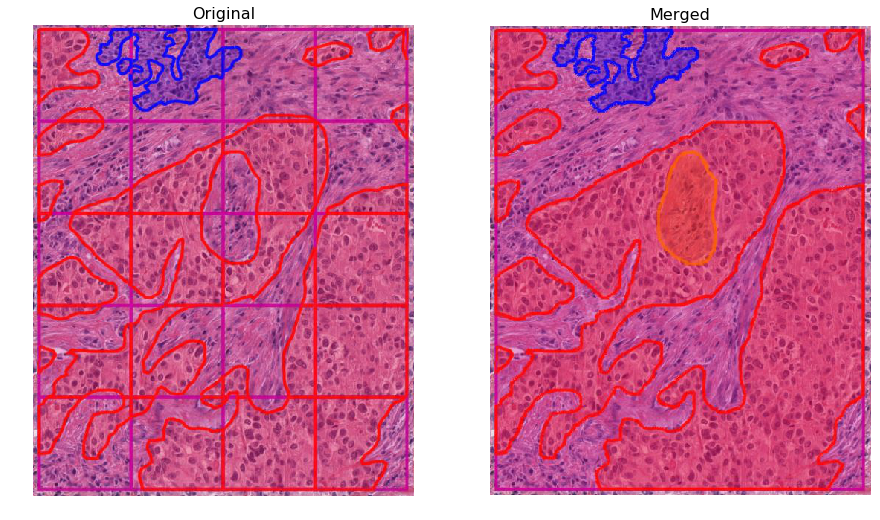

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

def _show_img(ax, path, title):
    ax.imshow(plt.imread(path))
    ax.set_title(title, fontsize=16)
    ax.axis('off')

IMGPATH = '../../histomicstk/annotations_and_masks/tests/test_files/img/'

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
_show_img(ax1, IMGPATH + 'polygon_merger_unmerged.jpg', 'Original')
_show_img(ax2, IMGPATH + 'polygon_merger_merged.jpg', 'Merged')

**Implementation summary**

This algorithm fuses polygon clusters in coordinate (not mask) space, which means is can merge almost-arbitrarily large structures without memory issues. The algorithm, in brief, works as follows:

- Identify contours that that have the same label (eg. tumor)

- Add the bounding boxes from these contours to an [R-tree](https://en.wikipedia.org/wiki/R-tree). The R-tree implementation used here is modified from [here](https://code.google.com/archive/p/pyrtree/), and uses k-means clustering to balance the tree. 

- Starting from the bottom of the tree, merge all polygons from leafs that belong to the same nodes.

- Move one level up the hierarchy, each time incoporated merged polygons from nodes that share a common parent. Do this until you get one merged polygon at the root node. The polygons are first dilated a bit to make sure any small gaps are covered, then they are merged and eroded. Note that ``shapely`` allows us to simply "combine" polygons into a "multi-polygon" object, which means we do not need to check if the polygons actually are within merger threshold. Instead, all polygons hierarchically combined until we arrive at a single "multi-polygon" object at the root node.

- Save the coordinares from each polygon on the multi-polygon object in a new pandas DataFrame. 

This process ensures that the number of comparisons is ``<< n^2``. This is very important since algorithm complexity plays a key role as whole slide images may contain tens of thousands of objects.

**Where to look?**

```
|_ histomicstk/
|   |_annotations_and_masks/
|      |_polygon_merger_v2.py 
|      |_tests/
|         |_ polygon_merger_v2_test.py
|_ docs/
    |_examples/
       |_polygon_merger_v2.ipynb
```

In [2]:
from __future__ import print_function

import os
import sys
CWD = os.getcwd()
sys.path.append(os.path.join(CWD, '..', '..', 'histomicstk', 'annotations_and_masks'))

import os
import girder_client
from pandas import read_csv

from polygon_merger_v2 import Polygon_merger_v2
from masks_to_annotations_handler import (
    get_annotation_documents_from_contours, _discard_nonenclosed_background_group)
from annotation_and_mask_utils import parse_slide_annotations_into_table

## 1. Constants & prep work

In [3]:
APIURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'
SOURCE_SLIDE_ID = '5d5d6910bd4404c6b1f3d893'
POST_SLIDE_ID = '5d586d76bd4404c6b1f286ae'

gc = girder_client.GirderClient(apiUrl=APIURL)
# gc.authenticate(interactive=True)
gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

# get and parse slide annotations into dataframe
slide_annotations = gc.get('/annotation/item/' + SOURCE_SLIDE_ID)
contours_df = parse_slide_annotations_into_table(slide_annotations)

## 2. Polygon merger

### This is the class object you will be using

In [4]:
print(Polygon_merger_v2.__doc__)

Methods to merge contiguous polygons from whole-slide image.


In [5]:
print(Polygon_merger_v2.__init__.__doc__)

Init Polygon_merger object.

        Arguments:
        -----------
        contours_df : pandas DataFrame
            The following columns are needed.

            group : str
                annotation group (ground truth label).
            ymin : int
                minimun y coordinate
            ymax : int
                maximum y coordinate
            xmin : int
                minimum x coordinate
            xmax : int
                maximum x coordinate
            coords_x : str
                vertix x coordinates comma-separated values
            coords_y
                vertix y coordinated comma-separated values
        merge_thresh : int
            how close do the polygons need to be (in pixels) to be merged
        verbose : int
            0 - Do not print to screen
            1 - Print only key messages
            2 - Print everything to screen
        monitorPrefix : str
            text to prepend to printed statements

        


### Required arguments for init

The only required argument is a dataframe of contours merge.

In [6]:
contours_df.head()

,annidx,elementidx,type,group,color,xmin,xmax,ymin,ymax,bbox_area,coords_x,coords_y
0,0,0,polyline,mostly_tumor,"rgb(255,0,0)",44457,44703,44191,44260,16974,"44614,44613,44608,44607,44602,44601,44596,4459...","44191,44192,44192,44193,44193,44194,44194,4419..."
1,0,1,polyline,mostly_tumor,"rgb(255,0,0)",44350,44682,43750,44154,134128,"44350,44350,44353,44354,44359,44360,44364,4436...","43750,44154,44151,44151,44146,44146,44142,4414..."
2,1,0,polyline,roi,"rgb(200,0,150)",44350,44860,43750,44260,260100,"44350,44350,44860,44860,44350","43750,44260,44260,43750,43750"
3,2,0,polyline,mostly_lymphocytic_infiltrate,"rgb(0,0,255)",44856,44860,43999,44034,140,"44860,44858,44858,44857,44857,44856,44856,4485...","43999,44001,44002,44003,44006,44007,44018,4401..."
4,2,1,polyline,mostly_lymphocytic_infiltrate,"rgb(0,0,255)",44788,44860,43912,43997,6120,"44823,44822,44819,44818,44817,44813,44812,4480...","43912,43913,43913,43914,43914,43918,43918,4392..."


## 3. Let's init and run the merger

In [7]:
# init & run polygon merger
pm = Polygon_merger_v2(contours_df, verbose=1)
pm.unique_groups.remove("roi")
pm.run()

: mostly_lymphocytic_infiltrate: set_contours_slice
: mostly_lymphocytic_infiltrate: create_rtree
: mostly_lymphocytic_infiltrate: set_tree_dict
: mostly_lymphocytic_infiltrate: set_hierarchy
: mostly_lymphocytic_infiltrate: get_merged_multipolygon
: mostly_lymphocytic_infiltrate: _add_merged_multipolygon_contours
: mostly_tumor: set_contours_slice
: mostly_tumor: create_rtree
: mostly_tumor: set_tree_dict
: mostly_tumor: set_hierarchy
: mostly_tumor: get_merged_multipolygon
: mostly_tumor: _add_merged_multipolygon_contours
: mostly_stroma: set_contours_slice
: mostly_stroma: create_rtree
: mostly_stroma: set_tree_dict
: mostly_stroma: set_hierarchy
: mostly_stroma: get_merged_multipolygon
: mostly_stroma: _add_merged_multipolygon_contours


__Note__: The following steps are only "aesthetic", and just ensure the contours look nice when posted to Digital Slide Archive for viewing with GeoGS. 

In [8]:
# add colors (aesthetic)
for group in pm.unique_groups:
    cs = contours_df.loc[contours_df.loc[:, "group"] == group, "color"]
    pm.new_contours.loc[
        pm.new_contours.loc[:, "group"] == group, "color"] = cs.iloc[0]

# get rid of nonenclosed stroma (aesthetic)
pm.new_contours = _discard_nonenclosed_background_group(
    pm.new_contours, background_group="mostly_stroma")

### This is the result

In [9]:
pm.new_contours.head()

,annidx,elementidx,type,group,color,xmin,xmax,ymin,ymax,bbox_area,coords_x,coords_y,has_holes
0,NaN,NaN,polyline,mostly_lymphocytic_infiltrate,"rgb(0,0,255)",44670.0,45472.0,43750.0,44200.0,360900.0,"44670,44670,44670,44670,44670,44670,44670,4467...","43901,43901,43907,43907,43908,43908,43909,4391...",0.0
1,NaN,NaN,polyline,mostly_tumor,"rgb(255,0,0)",46181.0,46396.0,43750.0,43917.0,35905.0,"46181,46181,46181,46181,46181,46181,46181,4618...","43777,43777,43777,43778,43778,43778,43778,4377...",0.0
2,NaN,NaN,polyline,mostly_tumor,"rgb(255,0,0)",46312.0,46396.0,44167.0,44350.0,15372.0,"46312,46312,46312,46312,46312,46312,46315,4631...","44252,44252,44252,44253,44253,44253,44256,4425...",0.0
3,NaN,NaN,polyline,mostly_tumor,"rgb(255,0,0)",44907.0,46396.0,44609.0,46308.0,2529811.0,"44907,44907,44907,44907,44907,44907,44907,4490...","46230,46230,46230,46234,46234,46234,46234,4623...",0.0
4,NaN,NaN,polyline,mostly_tumor,"rgb(255,0,0)",45822.0,46086.0,43824.0,43953.0,34056.0,"45822,45822,45822,45822,45822,45822,45822,4582...","43914,43914,43915,43915,43915,43915,43915,4391...",0.0


## 4. (Optional) - Visualize results on HistomicsTK

In [11]:
# deleting existing annotations in target slide (if any)
existing_annotations = gc.get('/annotation/item/' + POST_SLIDE_ID)
for ann in existing_annotations:
    gc.delete('/annotation/%s' % ann['_id'])

# get list of annotation documents
annotation_docs = get_annotation_documents_from_contours(
    pm.new_contours.copy(), separate_docs_by_group=True,
    docnamePrefix='test',
    verbose=False, monitorPrefix=POST_SLIDE_ID + ": annotation docs")

# post annotations to slide -- make sure it posts without errors
for annotation_doc in annotation_docs:
    resp = gc.post(
        "/annotation?itemId=" + POST_SLIDE_ID, json=annotation_doc)

Now you can go to:

[TCGA-A2-A0YE-01Z-00-DX1](http://candygram.neurology.emory.edu:8080/histomicstk#?image=5d586d76bd4404c6b1f286ae&bounds=41996%2C43277%2C49947%2C46942%2C0 )

and confirm that the posted annotations make sense and correspond to tissue boundaries and expected labels.